# MLFlow Experiment 1: Baseline Model

In [1]:
import os
os.chdir("../")
os.getcwd()

'c:\\Users\\amman\\Documents\\MLOPS\\Youtube-Sentiment-Insights'

In [3]:
# Quick mlflow test
import mlflow

mlflow.set_tracking_uri("http://ec2-18-209-5-28.compute-1.amazonaws.com:5000/")

with mlflow.start_run():
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", 0.89)

🏃 View run persistent-fox-998 at: http://ec2-18-209-5-28.compute-1.amazonaws.com:5000/#/experiments/0/runs/efd7be4cc5d84456a8c279ab5a156cbd
🧪 View experiment at: http://ec2-18-209-5-28.compute-1.amazonaws.com:5000/#/experiments/0


In [4]:
## Creating baseline model
import pandas as pd
import numpy as np 

In [5]:
df = pd.read_csv("data\youtube_comment_sentiment_cleaned.csv")
df.head()

,text,label
0,Anyone know movie is?,0
1,fact holding back equally aggressive :face_wit...,1
2,waiting next video be?,0
3,Thanks great video. understand DB continues ac...,0
4,Good person helping good people. America excep...,1


In [12]:
# Drop any missing values
df.dropna(inplace=True)
df.isnull().sum() # Check for missing values

text     0
label    0
dtype: int64

In [7]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42, stratify=df['label'])

In [15]:
# 2. Fit CountVectorizer ONLY on training data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

# 3. Transform test data using the SAME vectorizer (don't refit)
X_test_vec = vectorizer.transform(X_test)

In [16]:
# 4. Set mlflow tracking URI and experiment name
mlflow.set_tracking_uri("http://ec2-18-209-5-28.compute-1.amazonaws.com:5000/")
mlflow.set_experiment("RF Baseline Model")


2025/04/07 20:05:46 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-experiments-bucket1/265187508111733857', creation_time=1744052746450, experiment_id='265187508111733857', last_update_time=1744052746450, lifecycle_stage='active', name='RF Baseline Model', tags={}>

2025/04/07 20:26:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_Model at: http://ec2-18-209-5-28.compute-1.amazonaws.com:5000/#/experiments/265187508111733857/runs/b0037bffbee44932a316e3f3f23b03ae
🧪 View experiment at: http://ec2-18-209-5-28.compute-1.amazonaws.com:5000/#/experiments/265187508111733857
Accuracy: 0.5164730175362899


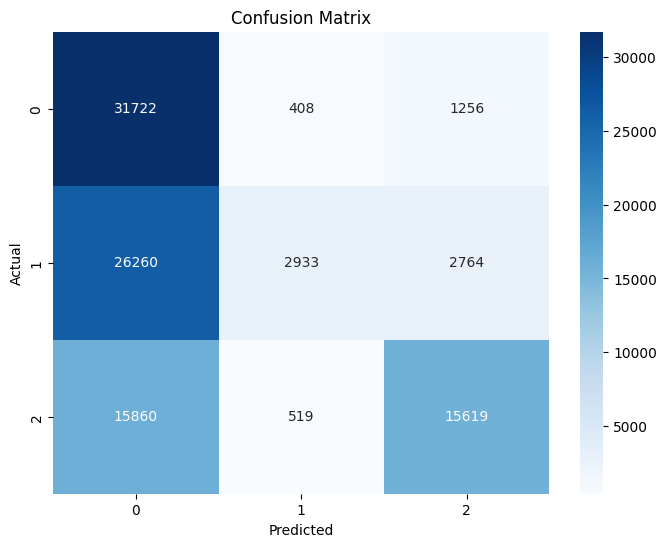

In [20]:
# 5. Start an MLflow run
with mlflow.start_run():
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_Model")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log parameters for the model
    n_estimators = 200
    max_depth = 15
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_vec)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself
    df.to_csv("data/dataset.csv", index=False)
    mlflow.log_artifact("data/dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")
